In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import pandas as pd

In [3]:

%matplotlib inline
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

#images = glob.glob('*.jpg')
#os.chdir('Cal/')
for fname in os.listdir('.'):
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    print (ret,corners)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

checkerboard1.jpg
(True, array([[[ 128.48412,  128.49858]],

       [[ 244.45041,  128.51608]],

       [[ 360.5002 ,  128.52043]],

       [[ 477.22025,  128.5156 ]],

       [[ 593.2064 ,  128.52118]],

       [[ 709.26465,  128.51524]],

       [[ 825.99585,  128.53027]],

       [[ 941.97815,  128.51422]],

       [[1058.0194 ,  128.53159]],

       [[ 128.42593,  244.55946]],

       [[ 244.45723,  244.51419]],

       [[ 360.45688,  244.54926]],

       [[ 477.24963,  244.58327]],

       [[ 593.2468 ,  244.52821]],

       [[ 709.2792 ,  244.57556]],

       [[ 825.9625 ,  244.5764 ]],

       [[ 942.01886,  244.54515]],

       [[1058.0333 ,  244.5585 ]],

       [[ 128.43893,  360.69568]],

       [[ 244.51999,  360.69   ]],

       [[ 360.44897,  360.69183]],

       [[ 477.23416,  360.67856]],

       [[ 593.12823,  360.6698 ]],

       [[ 709.3618 ,  360.68347]],

       [[ 825.90204,  360.72165]],

       [[ 942.08606,  360.62924]],

       [[1057.9103 ,  360.75592]],

   

In [3]:
import pickle
import pandas as pd

infile = open(filename,'rb')
dftype = pickle.load(infile)
infile.close()
print (dftype)

ValueError: unsupported pickle protocol: 4

In [6]:
import pandas as pd
filename = 'handle_videoDeepCut_resnet50_Demo2Jan30shuffle1_150000.h5'
pd.read_hdf(filename)

scorer    DeepCut_resnet50_Demo2Jan30shuffle1_150000                         \
bodyparts                                    Handle2                          
coords                                             x           y likelihood   
0                                         459.698007  644.095077   0.984066   
1                                         459.659744  643.862641   0.898935   
2                                         460.157639  645.001269   0.927753   
3                                         460.184307  644.414764   0.922327   
4                                         460.123447  644.362911   0.949559   
5                                         460.309819  644.382935   0.940193   
6                                         460.337280  643.989951   0.894790   
7                                         460.058171  644.032325   0.931594   
8                                         460.091916  643.665556   0.823999   
9                                         460.179054  643.873811   0.859642   
10                                        460.111809  644.105684   0.948210   
11                                        460.162704  644.058620   0.949083   
12                                        460.775349  645.611871   0.744201   
13                                        460.670418  644.997239   0.553514   
14                                        460.853478  644.946663   0.500921   
15                                        460.737954  644.620835   0.594497   
16                                        460.731504  644.563834   0.603671   
17                                        460.598934  644.974773   0.604118   
18                                        460.703841  644.940382   0.595788   
19                                        460.807677  644.682933   0.469658   
20                                        460.496166  644.493997   0.639191   
21                                        460.636905  644.217780   0.552394   
22                                        460.797839  644.342192   0.585696   
23                                        460.809218  644.340718   0.583028   
24                                        459.609526  644.069057   0.526094   
25                                        459.620590  644.222333   0.607410   
26                                        459.369897  643.855023   0.641267   
27                                        459.938687  644.110054   0.580519   
28                                        459.909480  643.969595   0.579831   
29                                        459.905756  644.107380   0.526046   
..                                               ...         ...        ...   
404                                       980.662813  628.499221   0.998133   
405                                       980.685695  628.432787   0.998135   
406                                       980.700560  628.597613   0.998320   
407                                       980.736422  628.630321   0.998552   
408                                       980.170480  628.393937   0.995241   
409                                       980.060585  628.367883   0.994804   
410                                       980.181692  628.556347   0.995269   
411                                       980.117931  628.477179   0.994959   
412                                       980.228479  628.527971   0.996030   
413                                       980.184663  628.622011   0.996345   
414                                       980.171736  628.585748   0.996118   
415                                       980.164472  628.568655   0.995761   
416                                       980.150071  628.569304   0.995883   
417                                       980.158342  628.490255   0.995930   
418                                       980.232054  628.258653   0.996714   
419                                       980.225272  628.337324   0.996728   
420                                       979.8327

In [8]:

import os
import cv2
vidcap = cv2.VideoCapture('handle_videoDeepCut_resnet50_Demo2Jan30shuffle1_150000_labeled.mp4')
success,image = vidcap.read()
os.chdir('images1/')
count = 0;
print "I am in success"
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame%d.png" % count, image)     # save frame as JPEG file
    if cv2.waitKey(10) == 27:                     # exit if Escape is hit
        break
    
    
    count += 1
    
    

I am in success


In [2]:
images_to_use = 'Cal_a'

with open(images_to_use + '_dict.pickle','rb') as handle:
    load_dict_a = pickle.load(handle)

In [3]:
print (load_dict_a['rvecs'])
print (load_dict_a['mtx'][1])

[array([[0.67680869],
       [0.39375118],
       [0.26930854]]), array([[ 0.35335647],
       [-0.30997884],
       [ 0.34349563]]), array([[ 0.7142498 ],
       [-0.49036431],
       [ 0.19467082]]), array([[ 0.64808332],
       [-0.31752842],
       [ 0.14218017]]), array([[ 0.47067851],
       [-0.02888669],
       [ 0.28545898]]), array([[ 0.30967622],
       [-0.60558712],
       [ 0.6077381 ]]), array([[ 0.68299229],
       [-0.42784582],
       [ 0.19807196]]), array([[ 0.16359291],
       [-0.8160923 ],
       [ 0.50839962]]), array([[ 0.62479485],
       [-0.3154203 ],
       [ 0.14631107]]), array([[ 0.40243924],
       [-0.26023948],
       [ 0.18183509]]), array([[ 0.50211882],
       [-0.83385954],
       [ 0.52265129]]), array([[0.69446583],
       [0.34157871],
       [0.25816943]]), array([[ 0.49252897],
       [-0.2929446 ],
       [ 0.16399814]]), array([[ 0.21061909],
       [-0.45471666],
       [ 0.42486632]]), array([[ 0.37159424],
       [-0.0755036 ],
       [ 

In [4]:
images_to_use = 'Cal_b'

with open(images_to_use + '_dict.pickle','rb') as handle:
    load_dict_b = pickle.load(handle)

In [46]:
ret_b = np.array(load_dict_b['ret'])
mtx_b=np.array(load_dict_b['mtx'])

dist_b = np.array(load_dict_b['dist'])

rvecs_b = np.array(load_dict_b['rvecs'])
tvecs_b = np.array(load_dict_b['tvecs'])
print (tvecs_b)
ret_a = np.array(load_dict_b['ret'])
mtx_a=np.array(load_dict_b['mtx'])
dist_a = np.array(load_dict_b['dist'])
rvecs_a = np.array(load_dict_b['rvecs'])
tvecs_a = np.array(load_dict_b['tvecs'])

# turn list of arrays into ND array

rvecs_b = np.mean(rvecs_b,axis = 0)
print (rvecs_b.shape)
tvecs_b = np.mean(tvecs_b,axis=0)
print (tvecs_b.shape)


# should return means element-wise 
# https://stackoverflow.com/questions/37443565/python-numpy-ndarray-element-wise-mean


[[[ -0.19274855]
  [-10.13519503]
  [ 29.77432543]]

 [[ -0.12982633]
  [-10.2681114 ]
  [ 29.79002582]]

 [[ -0.36085592]
  [-11.40208213]
  [ 27.08130641]]

 [[ -5.59808403]
  [-12.16008749]
  [ 32.32240098]]

 [[ -1.11202041]
  [-12.85732269]
  [ 31.41295148]]

 [[ -3.41386842]
  [-14.50900747]
  [ 39.12970441]]

 [[ -1.73568863]
  [-10.80875257]
  [ 26.32069531]]

 [[ -0.71680689]
  [-11.39198644]
  [ 27.11342852]]

 [[ -1.29417181]
  [-12.8701142 ]
  [ 31.47329042]]

 [[ -5.53235962]
  [-12.68801114]
  [ 35.87231111]]]
[[0.61848281]
 [0.71011778]
 [1.06302066]]
3


In [134]:
print (rvecs_b.shape,tvecs_b)

(3, 1) [[ -2.00864306]
 [-11.90906705]
 [ 31.02904399]]


In [129]:
# turn rotation vector into rotation matrix using Rodriguez formula.
# am using mean of rotation vectors found above.

rotation_mat = np.zeros(shape=(3, 3))
R_b = cv2.Rodrigues(rvecs_b, rotation_mat)[0]

print (R_b)
#P = np.column_stack((np.matmul(mtx_b,R), tvecs_b))
#print (P)

[[ 0.31128665 -0.55496852  0.7714341 ]
 [ 0.92513749  0.36259258 -0.11246   ]
 [-0.21730452  0.7486899   0.62629241]]


In [139]:
# calling camera 1 'a' primary
# calling camera 2 'b' secondary
R_T = np.column_stack((R_b,tvecs_b))
K_1 = mtx_a
K_2 = mtx_b
p1 = K_1 * np.identity(3)
zero_string = [0,0,0]
zero_string = np.array(zero_string)

p1 = np.column_stack((p1,zero_string))
p2 = np.matmul(K_2,  R_T)


In [140]:
print (p1.shape,p2.shape)

(3, 4) (3, 4)


In [ ]:
# Now I have values for a and B

# Now compose big matrix!!

# I choose camera A to be camera 1
# Camera B will be our R_T vector



#### Now Perform Triangulation for points.. see ####
def true_coords(projMatr1,projMatr2,projPoints1,projPoints2):
    # define true_points array? 
    true_points = cv2.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2)
    true_points = true_points / true_points[3]
    return true_points  #return normalized coordinates...




In [103]:
##### Load in DLC values #####
filename = 'handle_videoDeepCut_resnet50_Demo2Jan30shuffle1_150000.h5'
dataframe = pd.read_hdf(filename)

#### sort values by both probability, normalize pixels (due to two images



In [104]:
dataframe.keys()

MultiIndex(levels=[['DeepCut_resnet50_Demo2Jan30shuffle1_150000'], ['Handle1', 'Handle2'], ['likelihood', 'x', 'y']],
           labels=[[0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 2, 0, 1, 2, 0]],
           names=['scorer', 'bodyparts', 'coords'])

In [105]:
# sort by probability. 
dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['likelihood'] = dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['likelihood'] > .5
dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['likelihood'] = dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['likelihood'] > .5


#result_df = dataframe.loc[(dataframe.index.get_level_values(('DeepCut_resnet50_Demo2Jan30shuffle1_150000','Handle1','likelihood')) > .5) ]

In [106]:
print(dataframe)

scorer    DeepCut_resnet50_Demo2Jan30shuffle1_150000                         \
bodyparts                                    Handle2                          
coords                                             x           y likelihood   
0                                         459.698007  644.095077   0.984066   
1                                         459.659744  643.862641   0.898935   
2                                         460.157639  645.001269   0.927753   
3                                         460.184307  644.414764   0.922327   
4                                         460.123447  644.362911   0.949559   
5                                         460.309819  644.382935   0.940193   
6                                         460.337280  643.989951   0.894790   
7                                         460.058171  644.032325   0.931594   
8                                         460.091916  643.665556   0.823999   
9                                         460.179054

In [107]:
# # now I have my coordinates, extract coordinate pairs into a 2-D numpy array
handle_1_x = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['x'])
handle_1_y = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['y'])
handle_2_x = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['x'])
handle_2_y = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['y'])
handle_1_coords = np.vstack((handle_1_x, handle_1_y)).T
handle_2_coords = np.vstack((handle_2_x,handle_2_y)).T

print (handle_1_coords)

[[1835.63047796  771.64645165]
 [1836.2811279   771.84921762]
 [1835.80201204  771.7921762 ]
 [1835.73146906  771.7585749 ]
 [1835.69246128  771.78609915]
 [1835.6663211   771.79172881]
 [1835.66220218  771.78487666]
 [1835.65373996  771.77404365]
 [1835.69370562  771.75973274]
 [1835.70443776  771.77195756]
 [1835.71684581  771.77784747]
 [1835.7168459   771.77784747]
 [1831.3769629   771.36655307]
 [1831.51646376  771.20498562]
 [1831.40598774  771.24970692]
 [1831.32895803  771.29151678]
 [1831.33251333  771.29937559]
 [1831.27633262  771.40872294]
 [1831.27429438  771.39253795]
 [1831.27168536  771.39127719]
 [1831.27143002  771.39116567]
 [1831.27693105  771.39178938]
 [1831.28436899  771.40880591]
 [1831.28424978  771.40875465]
 [1833.59065652  772.28042251]
 [1833.58453131  772.24695387]
 [1833.54537606  772.21416108]
 [1833.54564571  772.21351822]
 [1833.5442822   772.21195216]
 [1833.54486966  772.21161565]
 [1833.54475999  772.2115868 ]
 [1833.54476047  772.21158658]
 [1833.5

In [108]:
# normalize x coordinates by pixel size of first image
# pixel size of first image = 2560/2 = 1280

for i in range (0,len(handle_1_coords)):
    handle_1_coords[i,0] = handle_1_coords[i,0] - 1280
    
print (handle_1_coords)

[[555.63047796 771.64645165]
 [556.2811279  771.84921762]
 [555.80201204 771.7921762 ]
 [555.73146906 771.7585749 ]
 [555.69246128 771.78609915]
 [555.6663211  771.79172881]
 [555.66220218 771.78487666]
 [555.65373996 771.77404365]
 [555.69370562 771.75973274]
 [555.70443776 771.77195756]
 [555.71684581 771.77784747]
 [555.7168459  771.77784747]
 [551.3769629  771.36655307]
 [551.51646376 771.20498562]
 [551.40598774 771.24970692]
 [551.32895803 771.29151678]
 [551.33251333 771.29937559]
 [551.27633262 771.40872294]
 [551.27429438 771.39253795]
 [551.27168536 771.39127719]
 [551.27143002 771.39116567]
 [551.27693105 771.39178938]
 [551.28436899 771.40880591]
 [551.28424978 771.40875465]
 [553.59065652 772.28042251]
 [553.58453131 772.24695387]
 [553.54537606 772.21416108]
 [553.54564571 772.21351822]
 [553.5442822  772.21195216]
 [553.54486966 772.21161565]
 [553.54475999 772.2115868 ]
 [553.54476047 772.21158658]
 [553.544765   772.21158962]
 [553.54475665 772.21153994]
 [553.54481268

In [110]:
# Now that coords are normalized, check size of arrays
print (handle_1_coords.shape,handle_2_coords.shape)

(434, 2) (434, 2)


In [141]:
# let's create our 3-D array from transform
true_points = true_coords(p1,p2,handle_1_coords[0,:],handle_2_coords[0,:])
print (true_points)

[[  15.74538334]
 [ -88.86650409]
 [-103.42468119]
 [   1.        ]]


In [153]:
#true_points_found = np.zeros(shape=(4,len(handle_1_coords)))
# create array to hold # points w/ 4xN structure
tupac = []
for i in range(0,len(handle_1_coords)):
    tupac.append(true_coords(p1,p2,handle_1_coords[i,:],handle_2_coords[i]))
    

true_points_found = np.array(tupac)   
print (true_points_found.shape)    


(434, 4, 1)


In [159]:
print (true_points_found[221,:,0])
true_gate = []
for i in range(0,434):
    true_gate.append(true_points_found[i,:,0])
    


true_gate = np.array(true_gate)
print (true_gate.shape)

[  16.00789834  -90.3773819  -105.10205166    1.        ]
(434, 4)


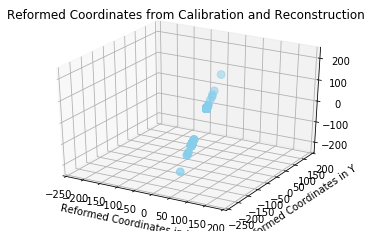

In [181]:
df = pd.DataFrame(true_gate, columns=list('XYZ1'))
    
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['X'], df['Y'], df['Z'], c='skyblue', s=60)
plt.xlabel('Reformed Coordinates in X')
plt.ylabel('Reformed Coordinates in Y')
#plt.zlabel('Reformed Coordinates in Z')
#plt.autoscale(enable=True)
ax.set_ylim(-250,200)
ax.set_xlim(-250,200)
ax.set_zlim(-240,240)
plt.title('Reformed Coordinates from Calibration and Reconstruction')
plt.savefig('Scatter_Recon.png')
#ax.view_init(30, 185)
plt.show()


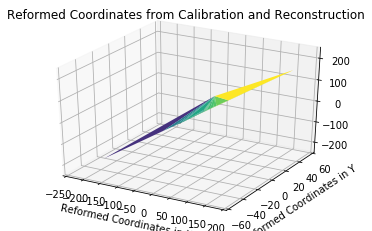

<Figure size 432x288 with 0 Axes>

In [185]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
plt.xlabel('Reformed Coordinates in X')
plt.ylabel('Reformed Coordinates in Y')
#plt.zlabel('Reformed Coordinates in Z')
#plt.autoscale(enable=True)
ax.set_ylim(-60,60)
ax.set_xlim(-250,200)
ax.set_zlim(-240,240)
plt.title('Reformed Coordinates from Calibration and Reconstruction')
plt.savefig('Reconstruction_heatmap.png')
plt.show()
 
# to Add a color bar which maps values to colors.
#surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
#fig.colorbar( surf, shrink=0.5, aspect=5)
plt.savefig('Reconstruction_heatmap.png')
plt.show()


In [171]:
df.to_hdf('Reconstruction_coordinates_handle.h5', key='df', mode='w')